# Weighing a fish

#### How do you weigh a fish without a scale? Regression of course!
Here I use regression to predict the weight of a fish given other size dimensions. The main focus will be on linear (and ridge) regression and train/test split cross-validation.

### Source of data:

Obtained from kaggle: https://www.kaggle.com/datasets/aungpyaeap/fish-market

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Some statistical modules for regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
%matplotlib inline

from matplotlib.lines import Line2D
plt.style.use('seaborn')

In [2]:
#Reading csv file into dataframe
fish = pd.read_csv("Fish.csv")
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


## 1) Some Data Exploration

In [3]:
#Checking for any missing values
fish.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

The data seems clean, but let's look closer at extreme entries.

In [4]:
#Max value
fish[ fish.Weight == fish.Weight.max() ]

,Species,Weight,Length1,Length2,Length3,Height,Width
144,Pike,1650.0,59.0,63.4,68.0,10.812,7.48


In [5]:
#Focussing on the species with max weight to check if the max point is consistent with other data points
fish[ fish.Species == "Pike" ].sort_values("Weight", ascending = False).head()

,Species,Weight,Length1,Length2,Length3,Height,Width
144,Pike,1650.0,59.0,63.4,68.0,10.8120,7.4800
142,Pike,1600.0,56.0,60.0,64.0,9.6000,6.1440
143,Pike,1550.0,56.0,60.0,64.0,9.6000,6.1440
141,Pike,1250.0,52.0,56.0,59.7,10.6863,6.9849
140,Pike,950.0,48.3,51.7,55.1,8.9262,6.1712


We see that the max value is not unusual and so leave it in the dataset.

In [6]:
#Min value
fish[ fish.Weight == fish.Weight.min() ]

,Species,Weight,Length1,Length2,Length3,Height,Width
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516


In [7]:
#Focussing on the species with min weight to check if the min point is consistent with other data points
fish[ fish.Species == "Roach"].sort_values("Weight").head()

,Species,Weight,Length1,Length2,Length3,Height,Width
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516
35,Roach,40.0,12.9,14.1,16.2,4.1472,2.2680
36,Roach,69.0,16.5,18.2,20.3,5.2983,2.8217
37,Roach,78.0,17.5,18.8,21.2,5.5756,2.9044
38,Roach,87.0,18.2,19.8,22.2,5.6166,3.1746


It does not make sense for fish to have zero weight even when it's dimensions are larger than other fishes of the same species. We will remove the min data point for simplicity.

In [8]:
#Dropping the weight = 0.0 value at index = 40
fish.drop( [40], inplace = True )
fish.reset_index()
fish[ fish.Species == "Roach"].sort_values("Weight").head()

,Species,Weight,Length1,Length2,Length3,Height,Width
35,Roach,40.0,12.9,14.1,16.2,4.1472,2.2680
36,Roach,69.0,16.5,18.2,20.3,5.2983,2.8217
37,Roach,78.0,17.5,18.8,21.2,5.5756,2.9044
38,Roach,87.0,18.2,19.8,22.2,5.6166,3.1746
41,Roach,110.0,19.1,20.8,23.1,6.1677,3.3957


<AxesSubplot:title={'center':'Average weight of each species'}, xlabel='Weight', ylabel='Species'>

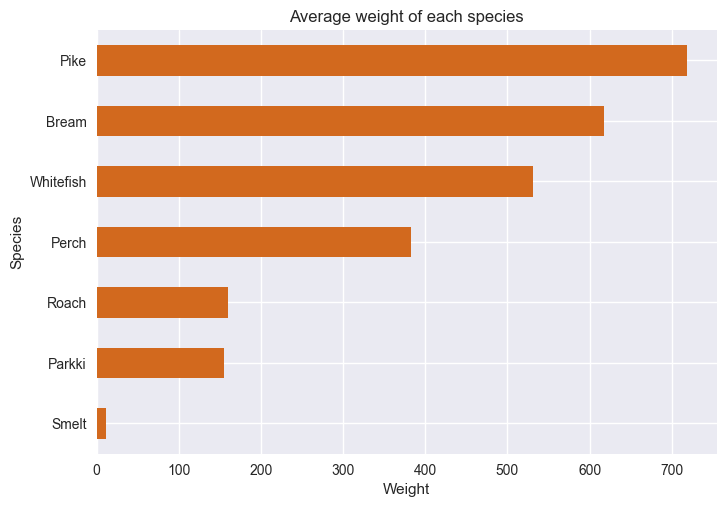

In [9]:
#Plotting the average weight for each species using groupby and dataframe plot
fish.groupby("Species")["Weight"].mean().to_frame().sort_values("Weight").plot(kind = 'barh', 
                        legend = False, xlabel = "Weight", title = "Average weight of each species", color = 'chocolate')

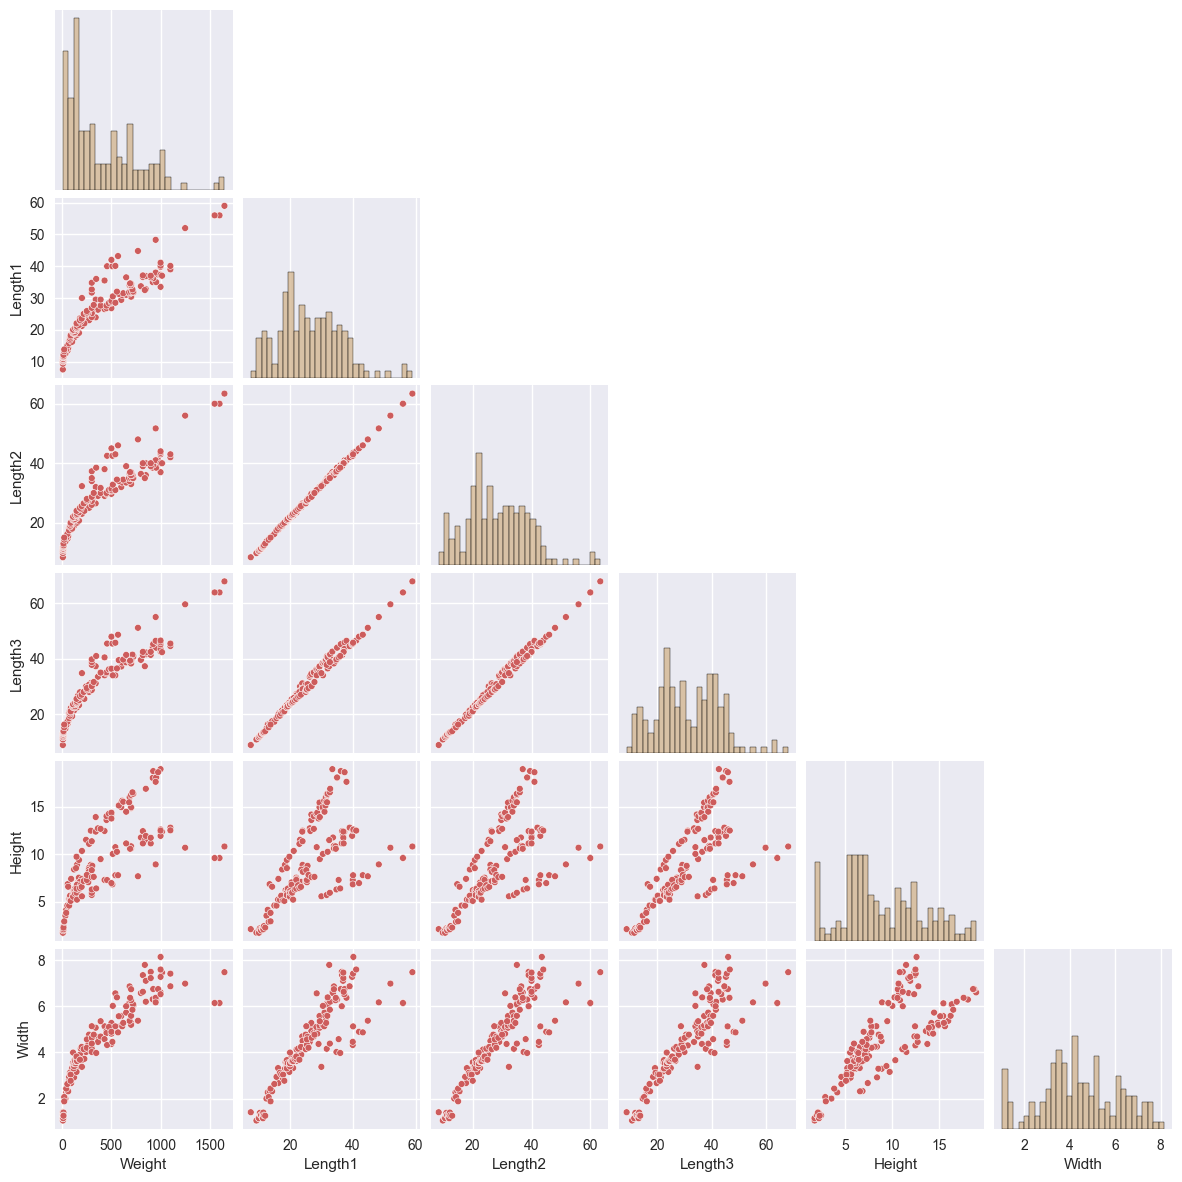

In [10]:
#plotting the numerical columns against each other: plot_kws, diag_kws allows the use of matplotlib commands 
#to set plot attributes for two, one variable plots respectively 
sns.pairplot(data = fish, height = 2, plot_kws={"size": 15, "color": 'indianred', "linewidths": 2, 
                                                "edgecolor": "white"}, diag_kws = {"color": 'tan', 'bins': 30}, corner = True)

Brief glance at the pair plot indicates multicollinearity since the lengths look highly correlated amongst each other; this suggests the use of ridge regression over linear. Nevertheless, we shall implement and compare both methods.

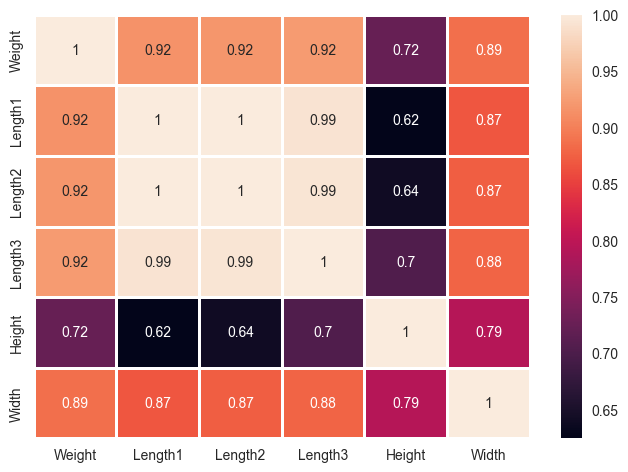

In [11]:
#Pearson r: correlation coefficients
ax = sns.heatmap( fish.corr(numeric_only = True), linewidth = 1, annot = True)

We see quantitative confirmation of the multicolinearily between the different lengths. Due to the high correlation we could potentially keep only a single type of length and still obtain a good (or maybe better) linear regression model.

Let's now focus on the target variable: Weight. From the first row we see that the correlation between weight and height is not as high as for the other explanatory variables. A visualisation according to the different species provides more insight.

In [12]:
fish["Species"].unique()

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

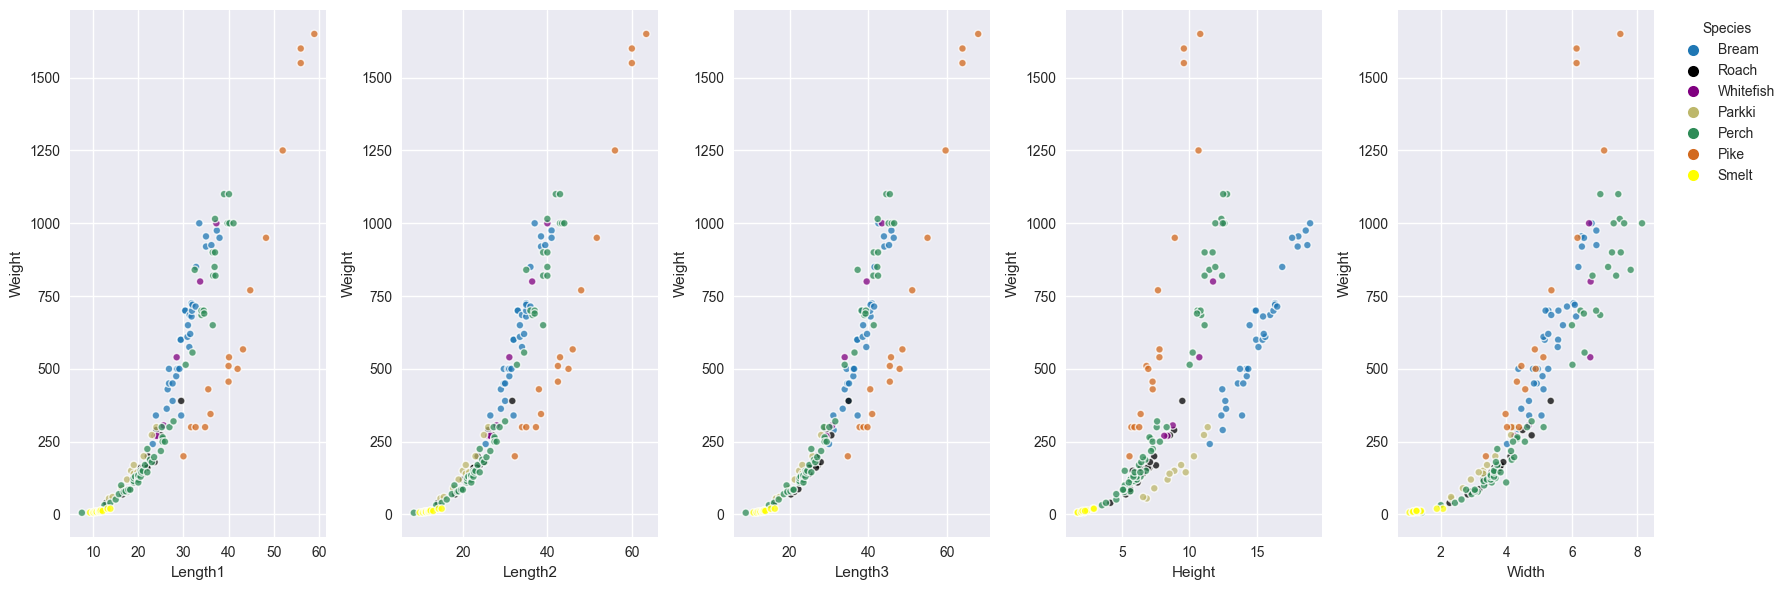

In [13]:
#Extracting the independent (explanatory) variables we want to explore; although the dataset is small, we try to avoid brute force
indp_var = []
for col in fish.columns:
    if col == "Species" or col == "Weight":
        continue
        
    else:
        indp_var.append( col )
        
#Defining a colour dictionary map using the Species column to be used like 'hue' in seaborn
col = {"Bream": 'tab:blue', "Roach": 'black' , "Whitefish": 'purple', "Parkki": 'darkkhaki', 
       "Perch": 'seagreen', "Pike": 'chocolate', "Smelt": 'yellow'}

#Making a figure object 
fig, ax = plt.subplots( ncols = len(indp_var), nrows = 1, figsize = (18,6))

#Adding plots (explanatory vs weight) to each of the axes, using matplotlib commands (instead of seaborn)
for index, axis in enumerate(ax):
    
    #Each iteration picks out the axes object in 'ax' and chooses the explanatory variable from 'indp_var'
    axis.scatter( fish[ indp_var[index] ], fish["Weight"], s = 30, linewidths = 1, edgecolor = 'w', 
                 c = fish["Species"].map(col), alpha = 0.75 ) 
    axis.set_xlabel( indp_var[index].title() )
    axis.set_ylabel( "Weight" )
    
    #Setting the legend only for the last (right most) axes object
    if index == len(ax) - 1:
        handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in col.items()]
        axis.legend(title = 'Species', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#Fixing label overlap issues etc 
plt.tight_layout()

Immediately, the Height vs Weight plot indicates a grouping according to the fish species and explains the lower correlation coefficient of ~ 0.72 (we also see small curvature for lower values on all the plots). As such, it might be more accurate to apply regression on the different clusters of fish species and try polynomial parameters. 

Since we don't have a surplus of data points to work with and aim to only demonstrate the techniques used for finding the optimum model for fixed explanatory parameters (relative comparison), we will treat Height as one of the explanatory variables without clustering. We will try out different polynomial features, however.

## 2) Linear Regression

In [14]:
#Checking the size of each explanatory variables
for var in indp_var:
    print(f"{fish[var].name}: {fish[var].mean()} \u00B1 {fish[var].std()}")

Length1: 26.29303797468354 ± 10.011427337604182
Length2: 28.465822784810122 ± 10.73170653320764
Length3: 31.28037974683544 ± 11.627605297326499
Height: 8.986789873417722 ± 4.295191030434185
Width: 4.424231645569621 ± 1.6890097693709165


The explanatory variables look roughly similar order in magnitude. 

Thus, the explanatory variables we will use are: 

- Length1
- Length2
- Length3 
- Height
- Width

Weight is the target variable.

### 2.1) Can linear regression fit the data?

To begin with, here we test if linear regression works well in just fitting the given data points and whether the assumption of normally distributed residue holds. 

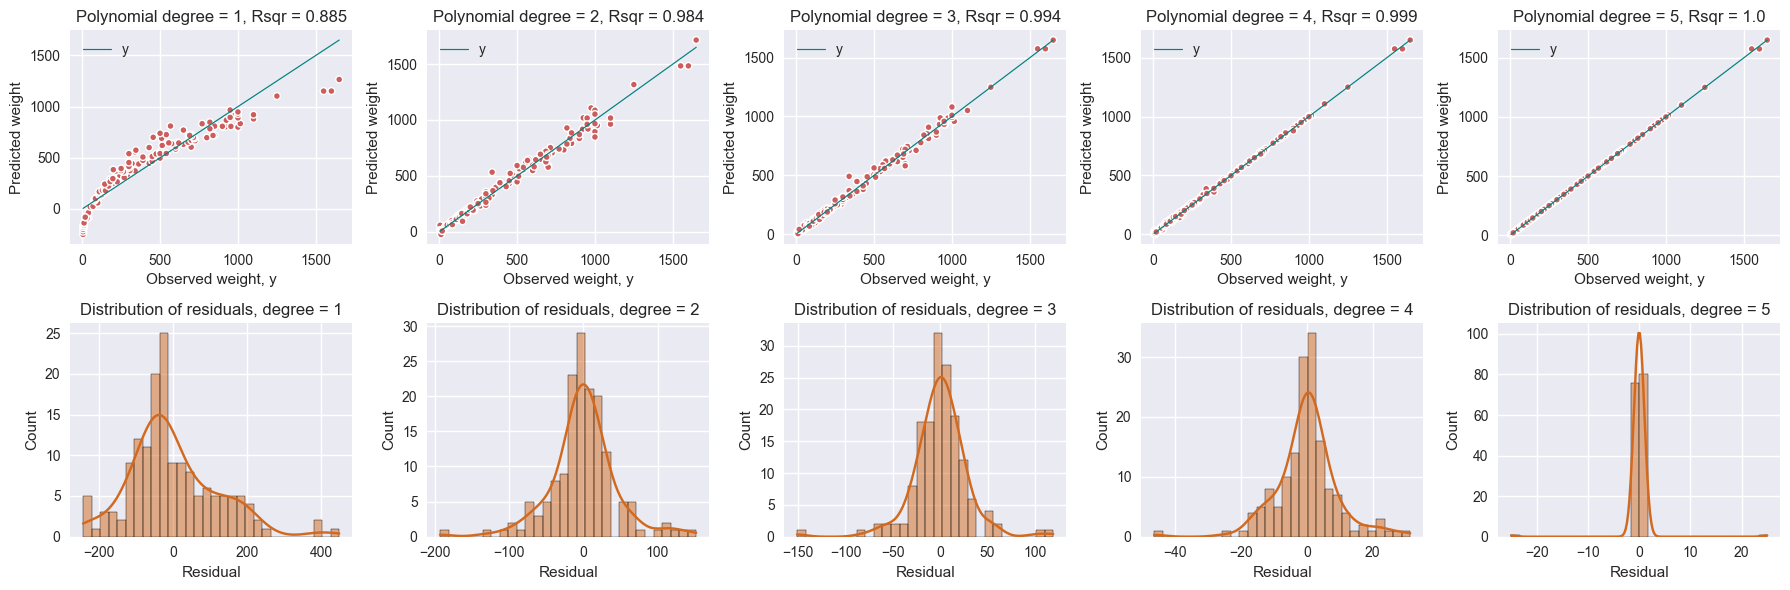

In [15]:
#Shallow copy: choosing the features
features = indp_var

#Independent (explanatory variable)
X = fish[features]

#Target variable
y = fish["Weight"].values

#Choosing the polynomial degrees to explore
degrees = [1,2,3,4,5]

#Creating figure object with subplots
fig, ax = plt.subplots( ncols = len(degrees), nrows = 2, figsize = (18,6) )

#Iteration over the different polynomial degrees to test the fitting capacity of linear regression
for index, deg in enumerate(degrees):
    
    #Creating a pipeline object to sequencially unify the polynomial terms generation and linear regression fit.
    #The include_bias is off since LinearRegression adds the intercept term by default
    pipe = Pipeline( [ ("Polynomial_terms", PolynomialFeatures(degree = deg, include_bias = False)), 
                  ("Regression_model", LinearRegression()) ] )
    
    #Fitting the data using linear regression
    pipe.fit( X, y )
    #Predicted weight using the fitted model
    y_predicted = pipe.predict( X )
    
    #Lineplot using seaborn showing the observed weights i.e. the data we have: using axes.legend() method
    sns.lineplot( x = y, y = y, ax = ax[0][index], linewidth = 0.85, color = "teal").legend( "y" )
    
    #Scatter plot of the predicted weights vs observed weight: using axes.set() 
    sns.scatterplot( x = y, y = y_predicted, ax = ax[0][index], size = 15, color = 'indianred', linewidth = 1, 
                    edgecolor = 'white', legend = False).set(xlabel = "Observed weight, y", ylabel = "Predicted weight",
                                                            title = f"Polynomial degree = {deg}, Rsqr = {round(pipe.score(X,y),3)}")
    
    #Residual distribution plot
    error = y - y_predicted
    sns.histplot( error, kde = True, ax = ax[1][index], bins = 30, color = "chocolate").set(xlabel = "Residual", 
                                                            title = f"Distribution of residuals, degree = {deg}")

#Fixing the layout  
plt.tight_layout()

We see that linear regression provides an increasingly good fit as the polynomial degree increases and the residuals are normally distributed with mean zero. This provides good justifications to try linear regression for the predictive model; here Rsqr is the coefficient of determination (R<sup> 2</sup>).

However, we look to have an issue of underfitting when deg = 1 and overfitting as deg > 3. Thus, the next step is to implement a train/test split cross-validation method to get a sense of the true generalisation error of the predictive model we would deploy. 

## 2.2) Train/Test Split Cross-Validation

We split the data into training and testing sets and use the test Rsqr value as an indication of the generalisation error.

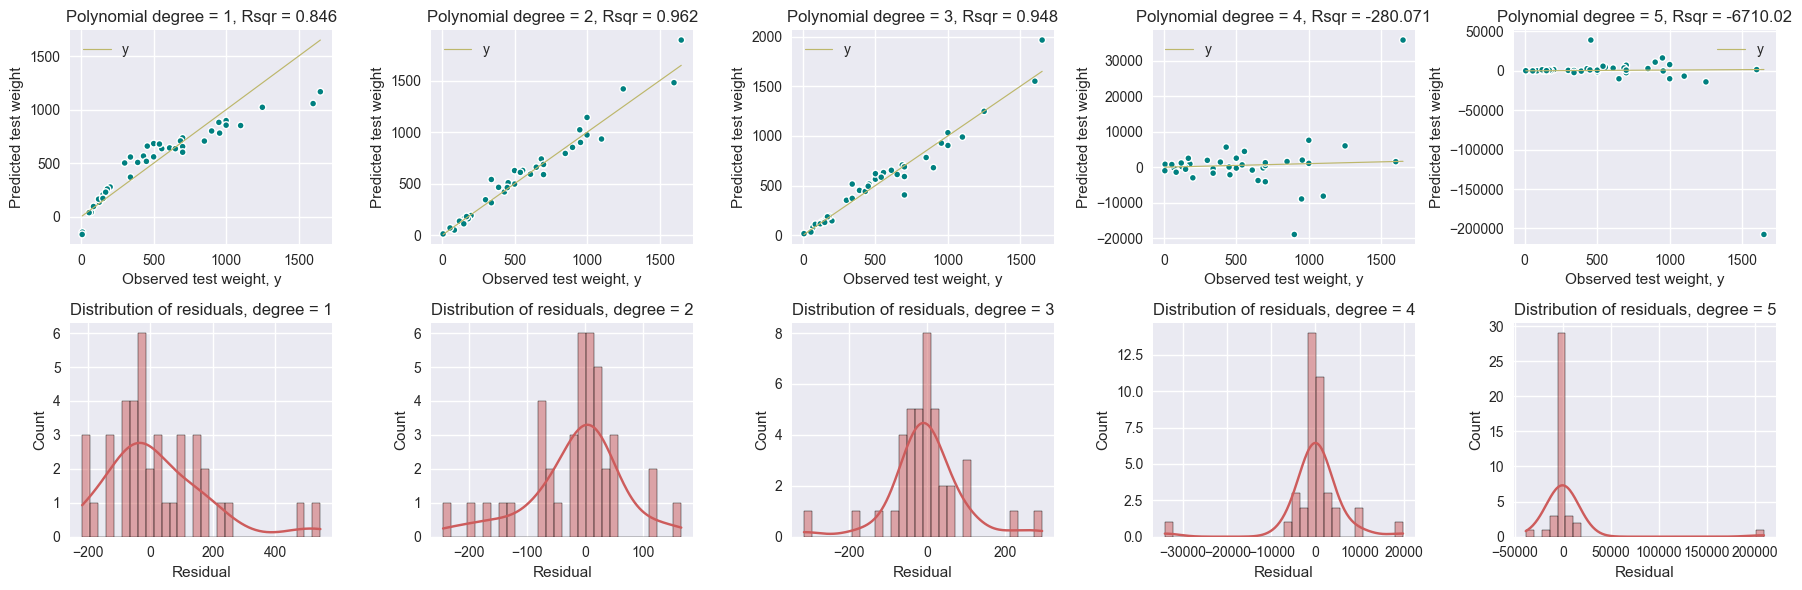

In [16]:
#Splitting the data into train and test (fixed random state for reproducability, for now)
X_train, X_test, y_train, y_test = train_test_split(fish[features], fish["Weight"], test_size=0.25, random_state = 200)

#Models to test 
degrees = [1,2,3,4,5]

#Creating figure object with subplots
fig, ax = plt.subplots( ncols = len(degrees), nrows = 2, figsize = (18,6) )

#Iteration over the different polynomial degrees to test the fitting capacity of linear regression
for index, deg in enumerate(degrees):
    
    #Creating a pipeline object to sequencially unify the polynomial terms generation and linear regression fit.
    #The include_bias is off since LinearRegression adds the intercept term by default
    pipe = Pipeline( [("Polynomial_terms", PolynomialFeatures(degree = deg, include_bias = False)), 
                  ("Regression_model", LinearRegression()) ] )
    
    #Training the linear regression model using training set
    pipe.fit( X_train, y_train )
    #Predicted weight using the test set
    y_predicted = pipe.predict( X_test )
    
    #Lineplot using seaborn showing the observed test weights 
    sns.lineplot( x = y_test, y = y_test, ax = ax[0][index], linewidth = 0.85, color = "darkkhaki").legend( "y" )
    
    #Scatter plot of the predicted test weights vs observed test weight
    sns.scatterplot( x = y_test, y = y_predicted, ax = ax[0][index], size = 15, color = 'teal', linewidth = 1, 
                    edgecolor = 'white', legend = False).set(xlabel = "Observed test weight, y", ylabel = "Predicted test weight",
                                                            title = f"Polynomial degree = {deg}, Rsqr = {round(pipe.score(X_test,y_test),3)}")
    
    #Residual distribution plot
    error = y_test - y_predicted
    sns.histplot( error, kde = True, ax = ax[1][index], bins = 30, color = "indianred").set(xlabel = "Residual", 
                                                            title = f"Distribution of residuals, degree = {deg}")

#Fixing the layout  
plt.tight_layout()

For this particular random state = 200, the best model is the degree two polynomial; capturing around 96% of the test data. Close second is the degree three polynomial ~ 95%, while the degree one is slightly underfitting. As expected, the higher order models are clearly overfitting to the training data and perform extremely bad (negative R<sup> 2</sup>) on the test dataset. 

To obtain a more concrete conclusion, we will try 100 different random states and take the average R<sup> 2</sup> value for each model/degree.

In [17]:
#Generating 100 random integers between 0 and 200
#rng = np.random.default_rng()
#rng.integers(low = 0, high = 200, size = 100)

#Copying the result of above code for reproducability
random = np.array([  0,  36, 124,  56, 160, 137, 189,  16, 137, 198, 107,  95,  57,
        31, 153, 176,  83,  72, 133, 104,  44, 107, 124, 183, 106,  27,
       170,  90, 126, 145,  22,  50,  79, 160,   6, 125,  85, 127,  88,
       174, 112, 175,  45,  12, 169, 197,  20, 163, 194,  72, 116,  85,
         0,  16,  50, 163, 198, 120, 168, 156,  73, 195, 190,  67, 191,
       118, 172, 172,  57, 189,  94,  79,  91, 138,  65, 166,  18,  28,
        86, 104,  35, 109,  66,  61,   3, 189,  53,  58, 176,  21, 144,
       106, 100,  34, 165, 148,  25, 191, 125,  26])

In [18]:
#Models to test 
degrees = [1,2,3,4,5]

#List to store the Rsqr value for each random_state and polynomial degree: total_score[random_state][degree] i.e. different random state per row and different degree per column
total_score = []

#Iteration over the 100 random numbers
for num in random:
    
    #List to append the Rsqr value for each polynomial degree
    score = []
    
    #Train/Test split for each random_state
    X_train, X_test, y_train, y_test = train_test_split(fish[features], fish["Weight"], test_size=0.25, random_state = num)
    
    #Iteration over each of the model degree
    for deg in degrees:
        
        #Pipeline object 
        pipe = Pipeline( [("Polynomial_terms", PolynomialFeatures(degree = deg, include_bias = False)), 
                  ("Regression_model", LinearRegression()) ] )
        
        #Training the model
        pipe.fit( X_train, y_train )
        
        #Adding Rsqr of the test data into the list 'score' 
        score.append( pipe.score( X_test, y_test ) )
    
    #Adding the list 'score' into the list 'total_score'
    total_score.append( score )
    
#Calculating the per column (axis = 0) mean of total_score i.e. the mean Rsqr value for each polynomial degree over the 100 random tests 
for index, num in enumerate( np.array(total_score).mean(axis = 0) ):
    print( f"Polynomial degree = {index + 1}, Rsqr = {round(num, 3)}" )

Polynomial degree = 1, Rsqr = 0.867
Polynomial degree = 2, Rsqr = 0.966
Polynomial degree = 3, Rsqr = 0.938
Polynomial degree = 4, Rsqr = -32190379.615
Polynomial degree = 5, Rsqr = -190416861.531


## 2.3) Conclusion: Linear Regression

Having used train/test cross-validation for 100 random splits, the best **linear regression** model to use for predicting fish weight is the **degree two polynomial** with average R<sup> 2</sup> value of 0.966, where the explanatory variables are Length1, Length2, Height and Width.

## 3) Ridge Regression

From the linear regression analysis in section 2, it is clear that the degree 2 polynomial fit had the best predictive capabilities. However, there still exists multicollinearity amongst the explanatory variables. Thus, in this section, we will attempt to use ridge regression to obtain a higher R<sup> 2</sup>. 

We will focus just on the degree 2 polynomial and tune the alpha parameter of the ridge regression to find the optimal value (amongst the ones we choose to explore).

In [19]:
from sklearn.linear_model import Ridge

In [20]:
#Choosing the values of alpha to explore
alphas = [0.01, 0.1, 1, 10, 100, 1000, 10000]

#Iteration over the chosen alpha values
for alpha in alphas:
    
    #List to store the Rsqr value of each random state
    tot_score = []

    #Iteration over the 100 random numbers (same as before, for comparison purposes)
    for num in random:
    
        #Train/Test split for each random_state
        X_train, X_test, y_train, y_test = train_test_split(fish[features], fish["Weight"], test_size=0.25, random_state = num)
    
        #Pipeline for ridge regression with poly deg = 2 
        ridge = Pipeline( [("Polynomial_terms", PolynomialFeatures(degree = 2, include_bias = False)), ("Regression_model", Ridge(alpha = alpha))] )
    
        #Training the model
        ridge.fit(X_train, y_train)
    
        #Rsqr value of the trained model as applied to the test data; appending to the list 'tot_score'
        tot_score.append( ridge.score(X_test, y_test) )
    
    #Printing the average Rsqr value for the 100 random_states, per alpha
    print( f"alpha = {alpha}, Rsqr = {round(np.array(tot_score).mean(),3)}" )    

alpha = 0.01, Rsqr = 0.966
alpha = 0.1, Rsqr = 0.967
alpha = 1, Rsqr = 0.969
alpha = 10, Rsqr = 0.971
alpha = 100, Rsqr = 0.973
alpha = 1000, Rsqr = 0.971
alpha = 10000, Rsqr = 0.96


For alpha = 100, we see that the average R<sup>2</sup> = 0.973. This is an increase of 0.7% compared to the linear regression model. Even though the increase is small, ridge regression does seem to perform better than linear regression when there exists multicollinearity amongst the explanatory variables.

A natural extension will be to test other regression models, cross-validation methods and optimisation techniques. 

## 4) Conclusion 

So, there we have it. The best way to weigh a fish<sup>*</sup> using regression is **Ridge Regression** with **alpha = 100** and **Polynomial Degree = 2**.

<sup>*</sup> Pike, Bream, Whitefish, Perch, Roach, Parkki and Smelt.

## Author

Abhay Shrestha